┌ Info: Recompiling stale cache file /Users/seanla/.julia/compiled/v1.0/Distributions/xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/seanla/.julia/compiled/v1.0/Clustering/Ovl2Q.ji for Clustering [aaaa29a8-35af-508c-8bc3-b662a17a0fe5]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/seanla/.julia/compiled/v1.0/RCall/8GFyb.ji for RCall [6f49c342-dc21-5d91-9882-a32aef131414]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/seanla/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1190
┌ Warning: `DataFrame(columns::AbstractMatrix)` is deprecated, use `DataFrame(columns, :auto)` instead.
│   caller = #generate#1(::Int64, ::Function, ::Main.Ntl.Models.Mixture{Main.Ntl.Models.NtlParameters{Main.Ntl.Models.GeometricArrivals},Main.Ntl.Models.GaussianParameters}) at synthetic.jl:266
└ @ Main.Ntl.Generate /Users/sea

100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, 0.0 it/s]


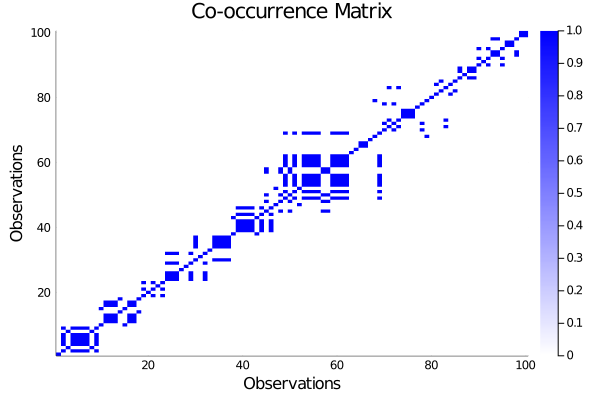

In [2]:
include("../ntl.jl")
import Random

using LinearAlgebra
Random.seed!(1)

data_covariance = Matrix{Float64}(0.1I, 2, 2)
prior_covariance = Matrix{Float64}(I, 2, 2)
prior_mean = Vector{Float64}(zeros(2))
data_parameters = Ntl.Models.GaussianParameters(data_covariance, prior_mean, prior_covariance)

psi_prior = Vector{Float64}([1, 1])
phi_prior = Vector{Float64}([1, 1])
geometric_arrival = Ntl.Models.GeometricArrivals(phi_prior)
ntl_cluster_parameters = Ntl.Models.NtlParameters(psi_prior, geometric_arrival)

mixture_model = Ntl.Models.Mixture(ntl_cluster_parameters, data_parameters)
mixture = Ntl.Generate.generate(mixture_model, n=100)
data = Matrix(transpose(mixture[:, 2:end]))
training_data = data[:, 1:100]
#test_datum = vec(data[:, 101])
true_clustering = mixture[:, 1]
Ntl.Plot.plot_assignments(true_clustering)
Ntl.Plot.plot_co_occurrence_matrix(true_clustering)

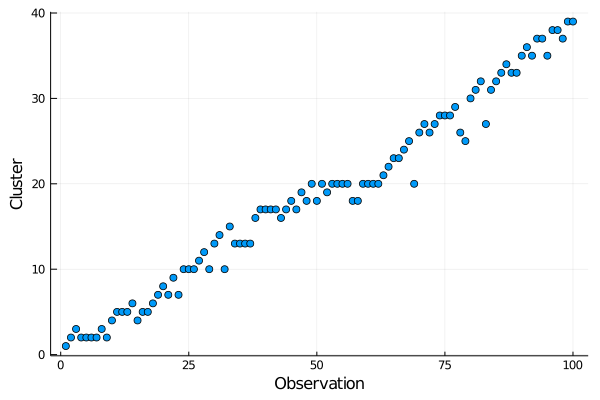

In [3]:
Ntl.Plot.plot_assignments(true_clustering)

In [15]:
num_clusters = Ntl.Utils.mean_num_clusters(true_clustering)
println("Number of clusters: $num_clusters")

Number of clusters: 39.0


100.0%┣█████████████████████████████████████┫ 1000/1000 [00:39<00:00, 25.9 it/s]
100.0%┣███████████████████████████████████┫ 1000/1000 [00:01<00:00, 1649.1 it/s]


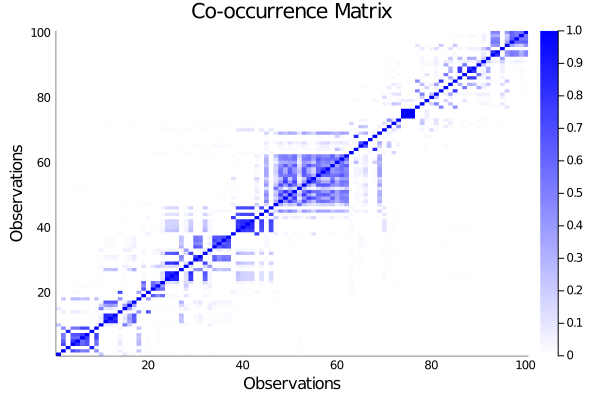

In [4]:
geometric_arrival = Ntl.Models.GeometricArrivals(phi_prior)
ntl_cluster_parameters = Ntl.Models.NtlParameters(psi_prior, geometric_arrival)
gibbs_sampler = Ntl.Samplers.GibbsSampler(num_iterations=1000)
(instances, log_likelihoods) = Ntl.Fitter.fit(training_data, mixture_model, gibbs_sampler)
Ntl.Plot.plot_co_occurrence_matrix(instances)

In [19]:
Ntl.Evaluate.evaluate(test_datum, instances, training_data, mixture_model)

-0.8503000835580822

In [ ]:
gibbs_num_clusters = Ntl.Utils.mean_num_clusters(instances)
println("Number of clusters: $gibbs_num_clusters")

Number of clusters: 43.21


100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, 0.0 it/s]


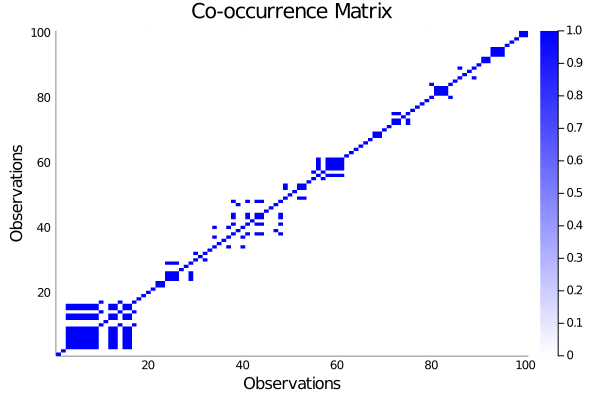

In [ ]:
map_estimate = Ntl.Utils.maximum_a_posterior(instances, log_likelihoods)
Ntl.Plot.plot_co_occurrence_matrix(map_estimate)


In [ ]:
map_num_clusters = length(unique(map_estimate))
println("MAP Estimate number of clusters: $map_num_clusters")

MAP Estimate number of clusters: 58


100.0%┣███████████████████████████████████┫ 1000/1000 [00:01<00:00, 1559.7 it/s]


┌ Warning: RCall.jl: Loading required package: lpSolve
└ @ RCall /Users/seanla/.julia/packages/RCall/eRsxl/src/io.jl:160


100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, 0.0 it/s]


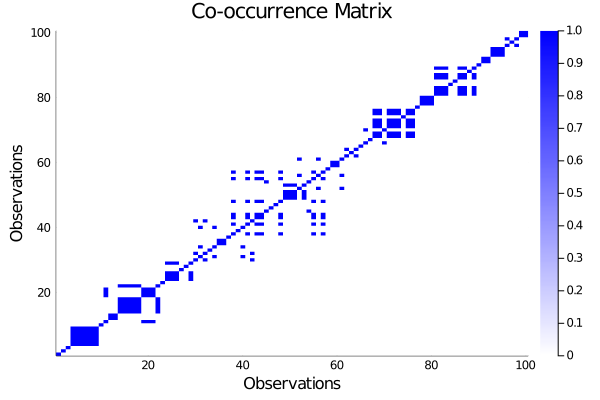

In [ ]:
psm = Ntl.Utils.compute_co_occurrence_matrix(instances)
binder_estimate = Ntl.Utils.minbinder(psm, instances)
Ntl.Plot.plot_co_occurrence_matrix(binder_estimate)

100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, 0.0 it/s]


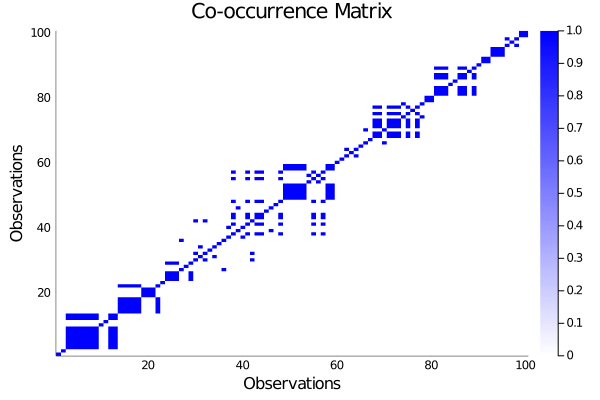

In [ ]:
vi_estimate = Ntl.Utils.minVI(psm, instances)
Ntl.Plot.plot_co_occurrence_matrix(vi_estimate)

100.0%┣████████████████████████████████████┫ 1000/1000 [00:03<00:00, 359.2 it/s]
100.0%┣███████████████████████████████████┫ 1000/1000 [00:00<00:00, 2086.8 it/s]


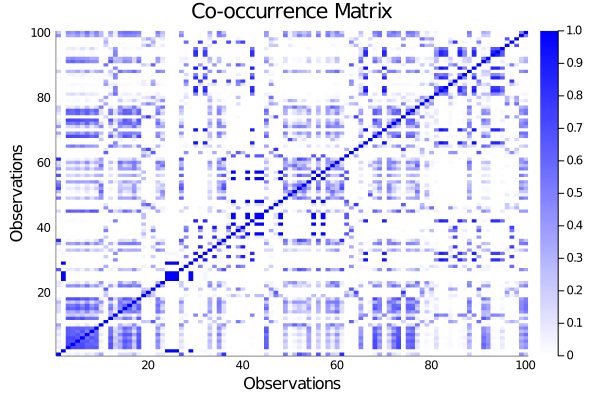

In [ ]:
dp_cluster_parameters = Ntl.Models.DpParameters(1)
dp_mixture = Ntl.Models.Mixture(dp_cluster_parameters, data_parameters)
gibbs_sampler = Ntl.Samplers.GibbsSampler(num_iterations=1000)
markov_chain, log_likelihoods = Ntl.Fitter.fit(training_data, dp_mixture, gibbs_sampler)
Ntl.Plot.plot_co_occurrence_matrix(markov_chain)

In [ ]:
Ntl.Evaluate.evaluate(test_datum, markov_chain, training_data, dp_mixture)

-1.149045628829536

100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, 0.0 it/s]


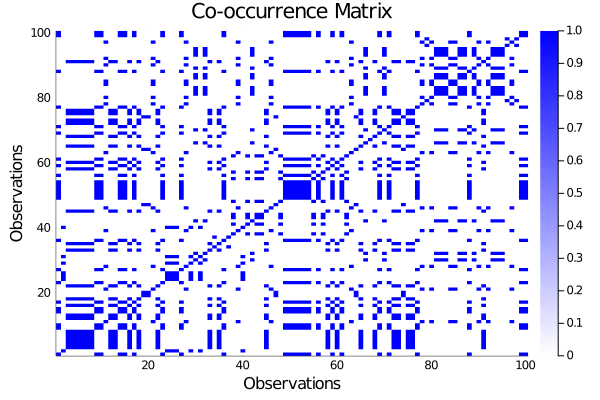

In [ ]:
dp_map_estimate = Ntl.Utils.maximum_a_posterior(markov_chain, log_likelihoods)
Ntl.Plot.plot_co_occurrence_matrix(dp_map_estimate)

100.0%┣███████████████████████████████████┫ 1000/1000 [00:01<00:00, 1688.8 it/s]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, 0.0 it/s]


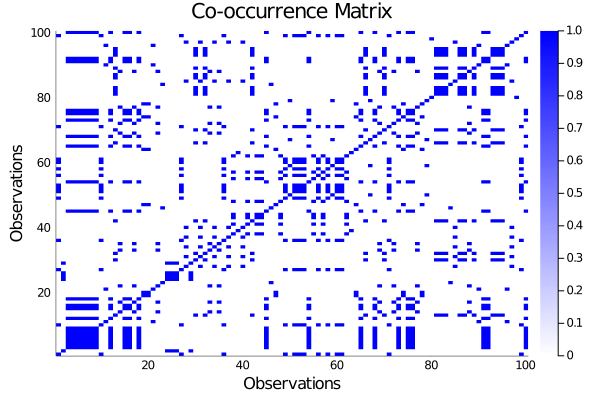

In [ ]:
dp_psm = Ntl.Utils.compute_co_occurrence_matrix(markov_chain)
dp_binder_estimate = Ntl.Utils.minbinder(dp_psm, markov_chain)
Ntl.Plot.plot_co_occurrence_matrix(dp_binder_estimate)

100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, 0.0 it/s]


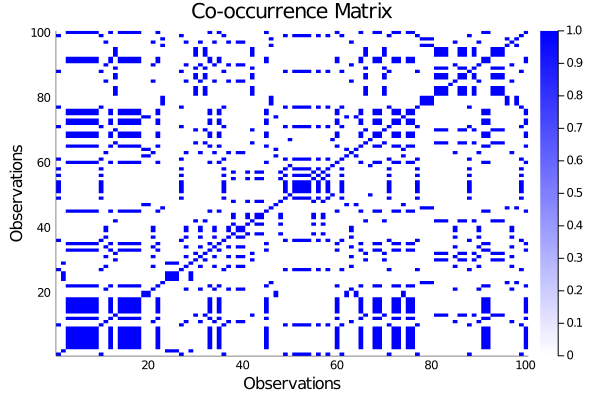

In [ ]:
dp_vi_estimate = Ntl.Utils.minVI(dp_psm, markov_chain)
Ntl.Plot.plot_co_occurrence_matrix(dp_vi_estimate)